In [1]:
%run setup.ipynb
%aimport peakfit

In [2]:
xpehh_raw = phase1_selection.xpehh_raw
xpehh_raw

Group(/, 5)
  groups: 5; 2L, 2R, 3L, 3R, X
  store: DirectoryStore

In [3]:
comparisons = list(xpehh_raw['X'])
comparisons

['AOMvsGWA',
 'BFMvsAOM',
 'BFMvsGWA',
 'BFSvsBFM',
 'BFSvsGWA',
 'BFSvsUGS',
 'CMS_savannavsBFS',
 'CMS_savannavsGAS',
 'CMS_savannavsGWA',
 'CMS_savannavsUGS',
 'GASvsAOM',
 'GASvsBFS',
 'GASvsGWA',
 'UGSvsGWA']

In [4]:
seqids

('2R', '2L', '3R', '3L', 'X')

In [5]:
sorted(genome)

['2L', '2R', '3L', '3R', 'UNKN', 'X', 'Y_unplaced']

In [6]:
def build_dataframe(focal_pop, ref_pop, flipped=False, seqid=None, window_size=800):
    
    if seqid is None:
        df = pd.concat([build_dataframe(focal_pop, ref_pop, flipped=flipped, seqid=seqid) for seqid in seqids])
        return df
        
    # extract raw values
    pop1, pop2 = focal_pop, ref_pop
    if flipped:
        pop1, pop2 = pop2, pop1
    comparison = '%svs%s' % (pop1, pop2)
    grp = xpehh_raw[seqid][comparison]
    pos = grp['POS'][:]
    values = grp['XPEHH_zscore'][:]
    if flipped:
        values = -values
    nomiss = ~np.isnan(values) & (values > 0)
    pos_nomiss = pos[nomiss]
    values_nomiss = values[nomiss]
    
    # construct moving windows
    starts_col = allel.moving_statistic(pos_nomiss, statistic=lambda v: v[0], size=window_size)
    starts_col[0] = 1  # fix to start of sequence
    ends_col = np.append(starts_col[1:] - 1, [len(genome[seqid])])
    
    # summarise values in windows
    values_col = allel.moving_statistic(values_nomiss, statistic=np.max, size=window_size)
    
    # seqid column
    seqid_col = np.array([seqid] * len(starts_col))
    
    # build dataframe
    df = pd.DataFrame.from_items([
        ('seqid', seqid_col), 
        ('start', starts_col), 
        ('end', ends_col), 
        ('value', values_col)
    ])
    return df

    
    

## Sandbox

In [7]:
df = build_dataframe('BFS', 'GWA')
df.head()

/home/aliman/src/github/malariagen/agam-selection-atlas/deps/conda/envs/agam-selection-atlas/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


,seqid,start,end,value
0,2R,1,31433,1.668300
1,2R,31434,49729,2.674605
2,2R,49730,73462,1.483737
3,2R,73463,93497,2.058329
4,2R,93498,111305,2.049382


In [8]:
df.tail()

,seqid,start,end,value
1034,X,19389971,19410088,1.454079
1035,X,19410089,19650094,1.169734
1036,X,19650095,19841714,1.142727
1037,X,19841715,23372431,1.400026
1038,X,23372432,24393108,2.094701


In [9]:
starts, ends, gstarts, gends, values, percentiles = peakfit.extract_windowed_values(df, seqid=('2R', '2L'), recmap=recmap, genome=genome)

In [10]:
starts

array([        1,     31434,     49730, ..., 110775286, 110790100,
       110817412], dtype=int32)

In [11]:
ends

array([    31433,     49729,     73462, ..., 110790099, 110817411,
       110909430])

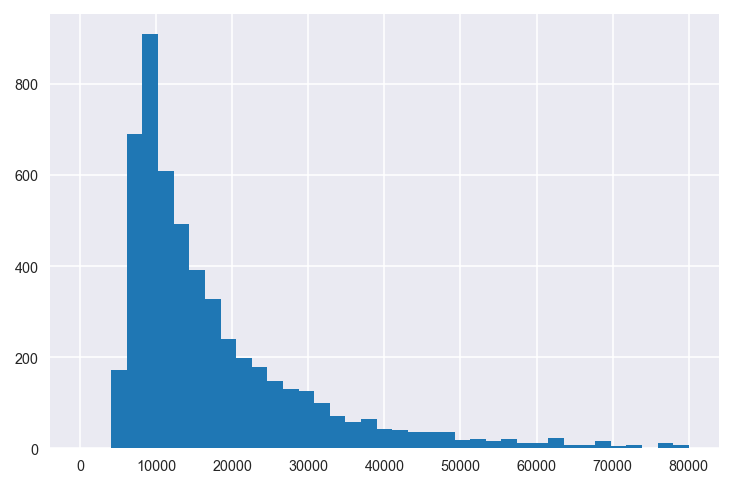

In [12]:
plt.hist(ends-starts, bins=np.linspace(0, 80000, 40));

In [13]:
gstarts

array([  0.00000000e+00,   6.28660000e-02,   9.94580000e-02, ...,
         2.12385207e+02,   2.12414835e+02,   2.12469459e+02])

In [14]:
gends

array([  6.28660000e-02,   9.94580000e-02,   1.46924000e-01, ...,
         2.12414835e+02,   2.12469459e+02,   2.12653497e+02])

In [15]:
gstarts.shape, gends.shape, starts.shape, ends.shape

((5396,), (5396,), (5396,), (5396,))

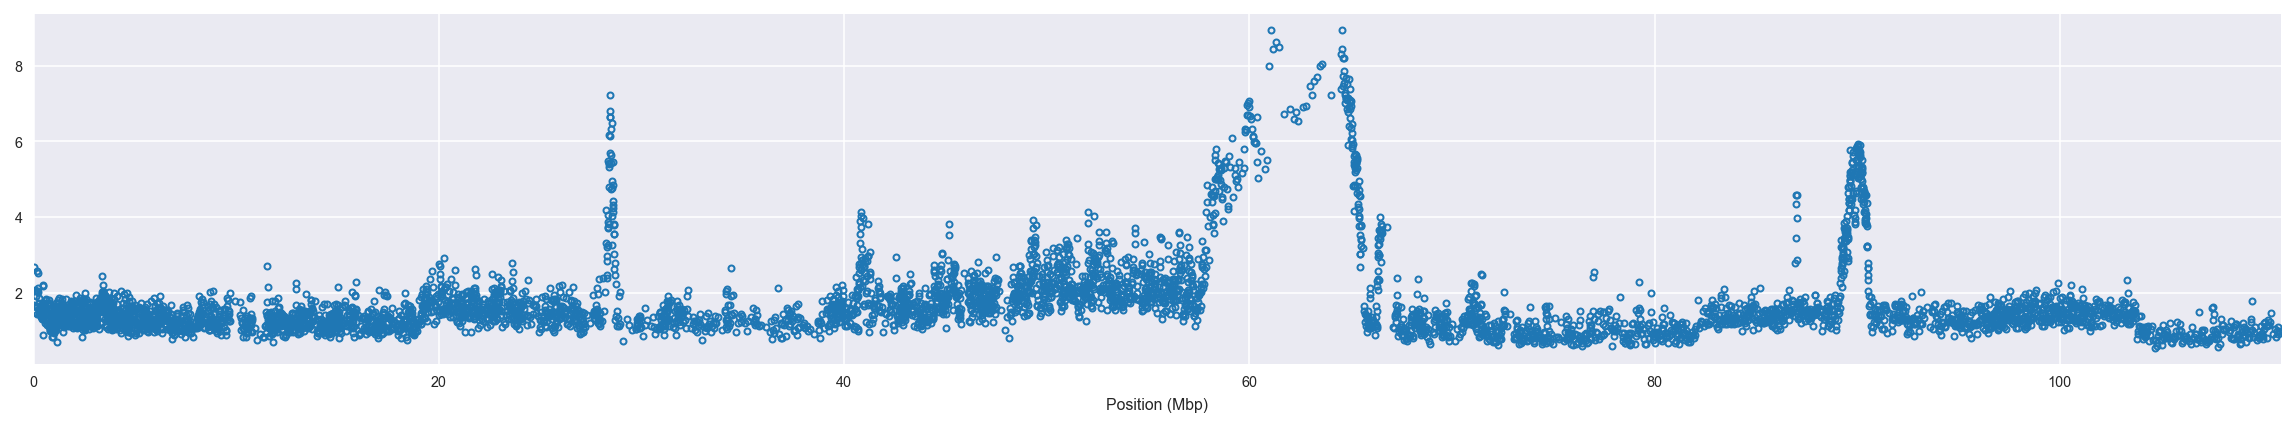

In [17]:
peakfit.plot_windowed_values(starts / 1e6, ends / 1e6, values, xlabel='Position (Mbp)');

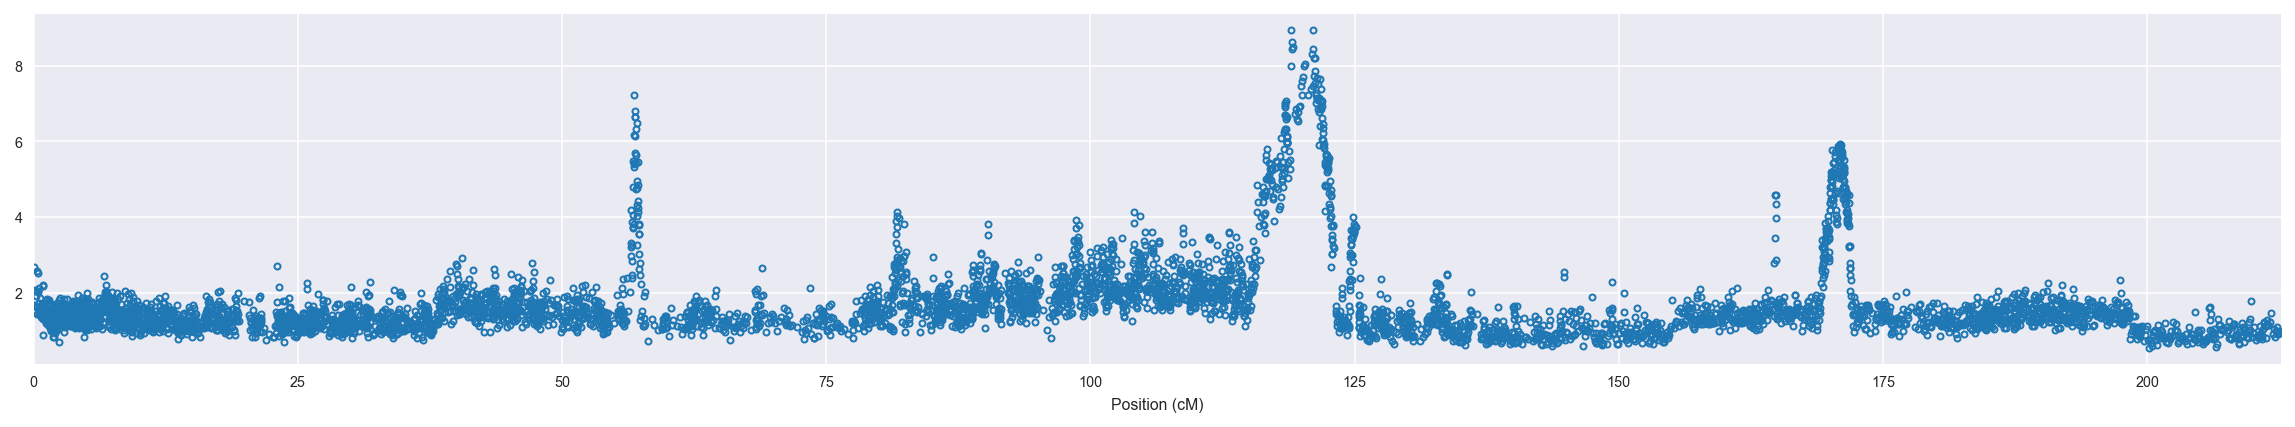

In [18]:
peakfit.plot_windowed_values(gstarts, gends, values, xlabel='Position (cM)');

In [19]:
x = .99

In [20]:
y = -10 * np.log10(1 - x)
y

19.999999999999996

In [21]:
1 - 10**(y / -10)

0.98999999999999999

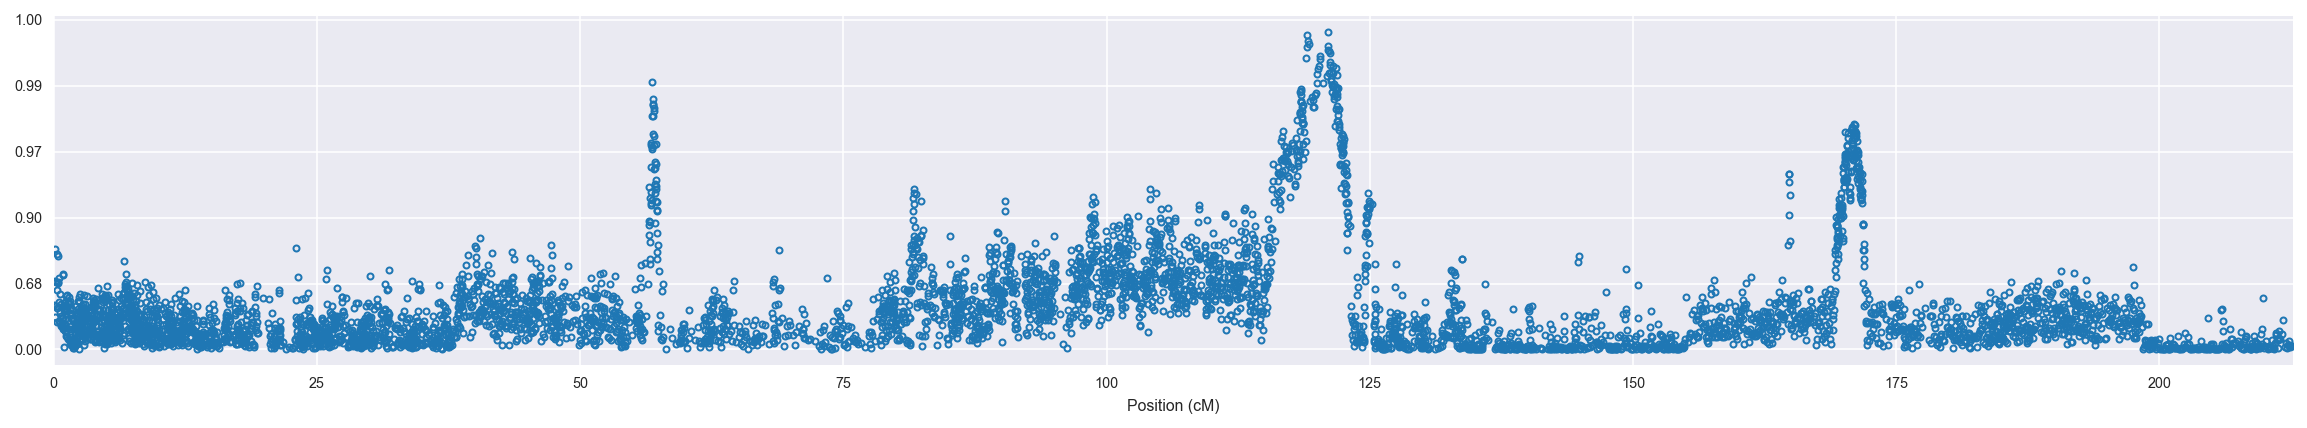

In [22]:
ax = peakfit.plot_windowed_values(gstarts, gends, -10 * np.log10(1 - percentiles), xlabel='Position (cM)')
yticklabels = ['{:.2f}'.format(1 - 10**(y / -10)) for y in ax.get_yticks()]
ax.set_yticklabels(yticklabels);

In [23]:
symexp_fitter = peakfit.ExponentialPeakFitter(
    amplitude=lmfit.Parameter(value=3, vary=True, min=0),
    decay=lmfit.Parameter(value=0.2, vary=True, min=0.05, max=3),
    baseline=lmfit.Parameter(value=1, vary=True, min=0, max=5),
    ceiling=lmfit.Parameter(value=5, vary=True, min=0),
    floor=lmfit.Parameter(value=0, vary=False),
    null=lmfit.Parameter(value=1, vary=True, min=0)
)


In [24]:
asymexp_fitter = peakfit.AsymmetricDecayExponentialPeakFitter(
    amplitude=lmfit.Parameter(value=3, vary=True, min=0),
    decay_left=lmfit.Parameter(value=0.2, vary=True, min=0.05, max=3),
    decay_right=lmfit.Parameter(value=0.2, vary=True, min=0.05, max=3),
    baseline=lmfit.Parameter(value=1, vary=True, min=0, max=5),
    ceiling=lmfit.Parameter(value=5, vary=True, min=0),
    floor=lmfit.Parameter(value=0, vary=False),
    null=lmfit.Parameter(value=1, vary=True, min=0)
)


In [34]:
def inspect_peak_fits(center, flank):

    x = (gstarts + gends) / 2
    y = values

    fit = symexp_fitter.fit(x, y, center, flank)
    fig = peakfit.plot_peak_fit_diagnostics(fit, dpi=150, ylabel='max XPEHH')
    fig.suptitle('Exponential peak', fontsize=12, fontweight='bold', y=1.03)
    plt.show()
    print(fit.peak_result.fit_report())

    fit = asymexp_fitter.fit(x, y, center, flank)
    fig = peakfit.plot_peak_fit_diagnostics(fit, dpi=150, ylabel='max XPEHH')
    fig.suptitle('Exponential peak with asymmetric decay', fontsize=12, fontweight='bold', y=1.03)
    plt.show()
    print(fit.peak_result.fit_report())

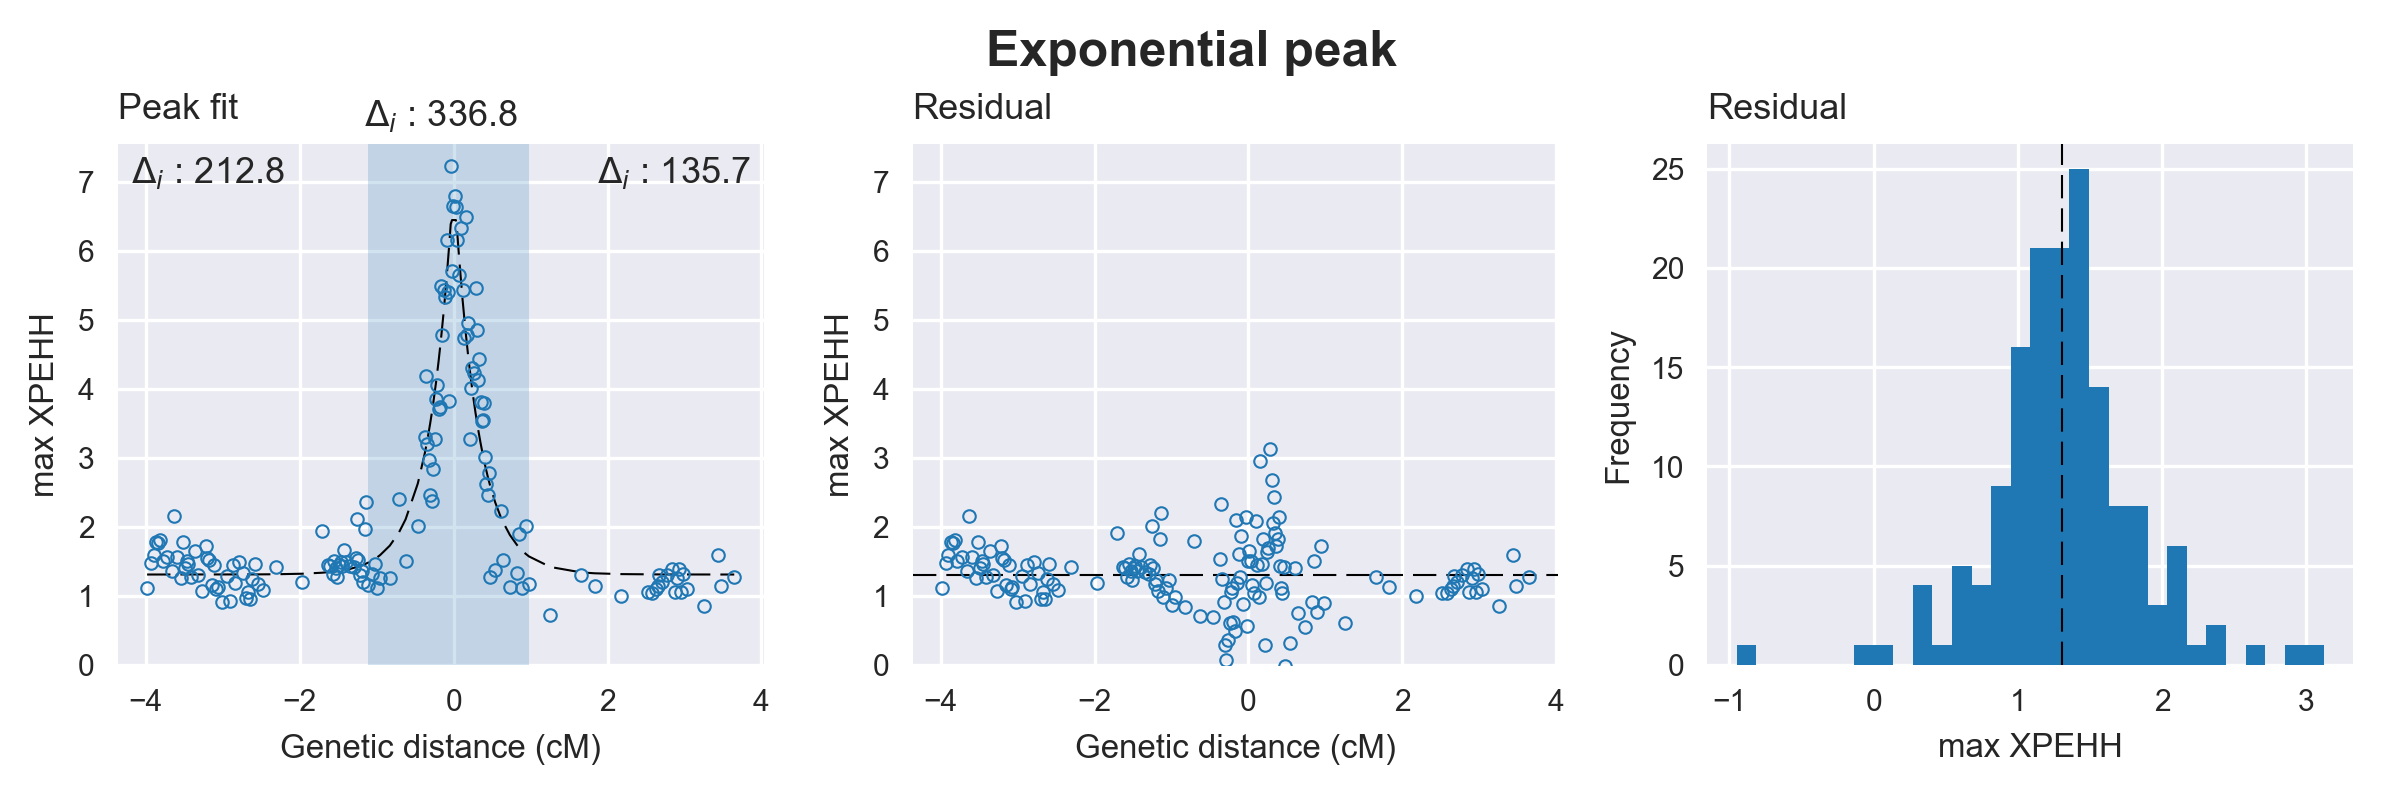

[[Model]]
    Model(exponential_peak)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 154
    # variables        = 4
    chi-square         = 40.997
    reduced chi-square = 0.273
    Akaike info crit   = -195.811
    Bayesian info crit = -183.663
[[Variables]]
    center:      0 (fixed)
    amplitude:   5.73270533 +/- 0.251796 (4.39%) (init= 3)
    decay:       0.31707965 +/- 0.023678 (7.47%) (init= 0.2)
    baseline:    1.30825780 +/- 0.057194 (4.37%) (init= 1)
    ceiling:     6.44241101 +/- 0.261397 (4.06%) (init= 5)
    floor:       0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, decay)          = -0.719 
    C(decay, baseline)           = -0.444 



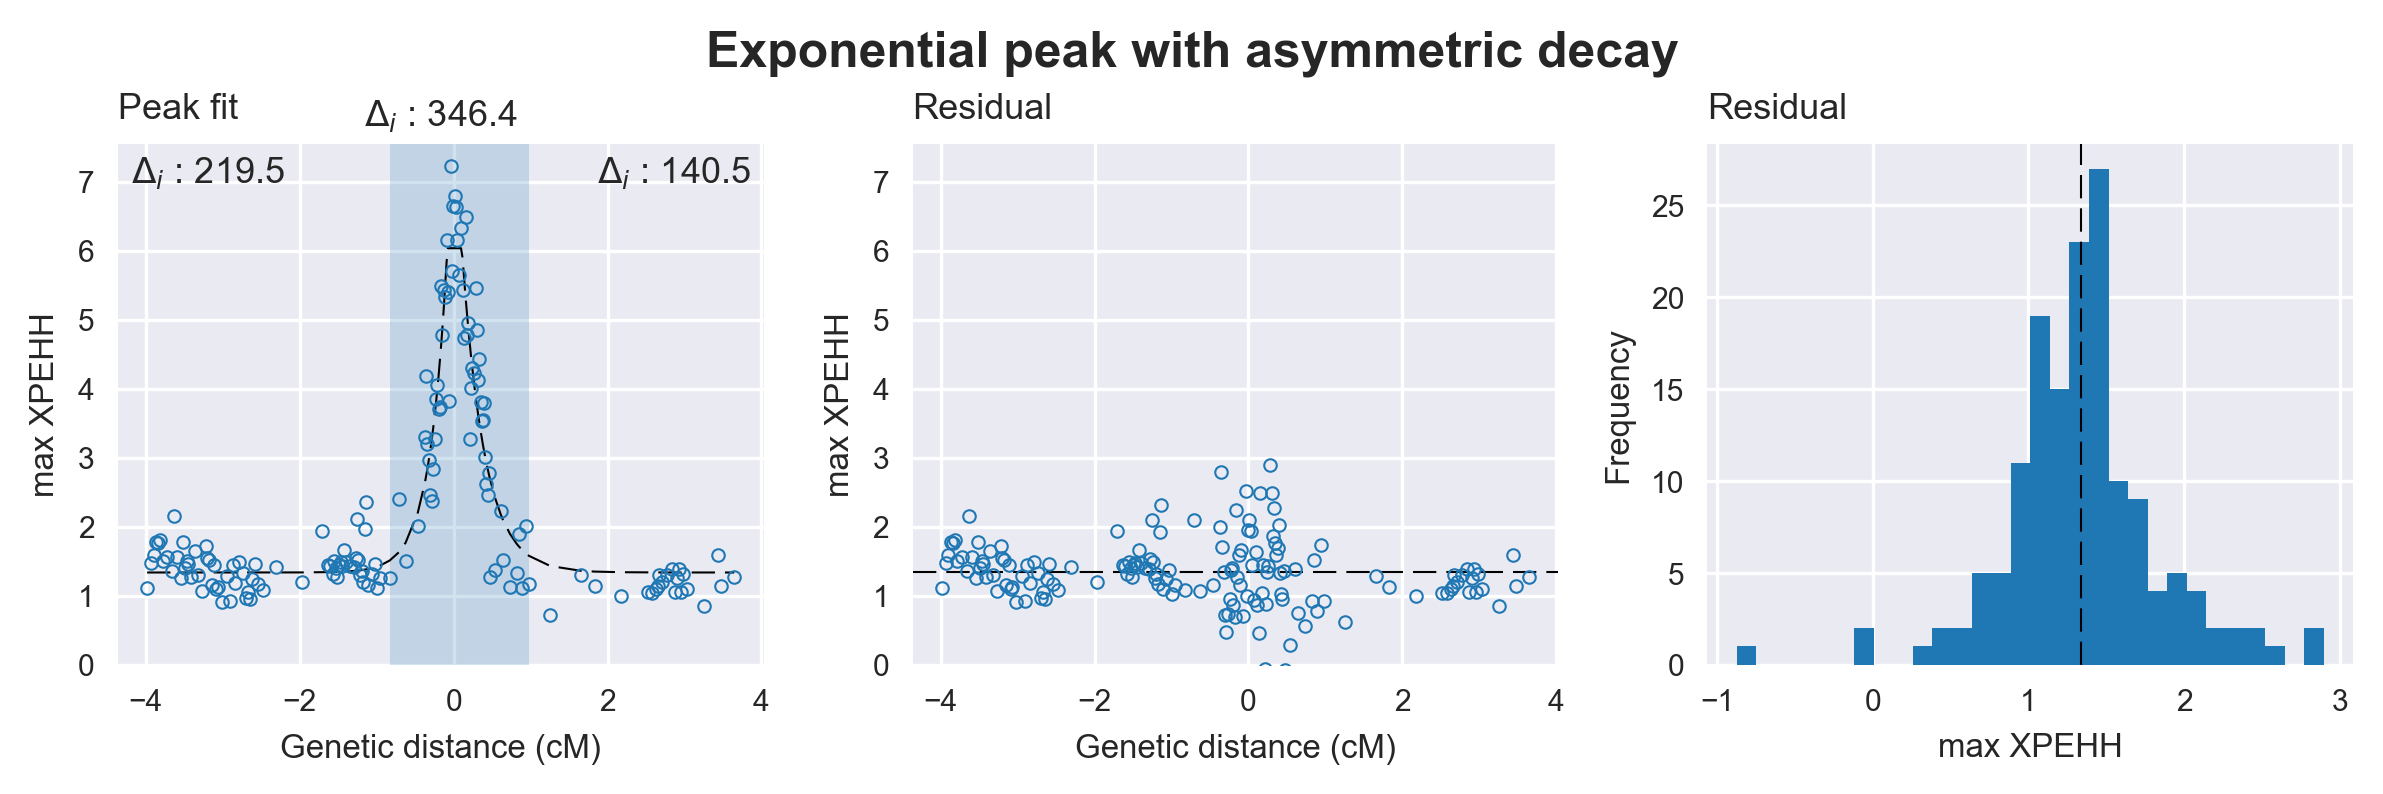

[[Model]]
    Model(asymmetric_decay_exponential_peak)
[[Fit Statistics]]
    # function evals   = 57
    # data points      = 154
    # variables        = 5
    chi-square         = 38.028
    reduced chi-square = 0.255
    Akaike info crit   = -205.390
    Bayesian info crit = -190.205
[[Variables]]
    center:        0 (fixed)
    amplitude:     6.74462192 +/- 0.462345 (6.86%) (init= 3)
    decay_left:    0.22723053 +/- 0.021430 (9.43%) (init= 0.2)
    decay_right:   0.29382076 +/- 0.025666 (8.74%) (init= 0.2)
    baseline:      1.33753040 +/- 0.053158 (3.97%) (init= 1)
    ceiling:       6.03460202 +/- 0.159756 (2.65%) (init= 5)
    floor:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, decay_right)    = -0.819 
    C(amplitude, decay_left)     = -0.793 
    C(decay_left, decay_right)   =  0.728 
    C(decay_right, baseline)     = -0.353 
    C(decay_left, baseline)      = -0.341 



In [35]:
inspect_peak_fits(center=56.9, flank=4)

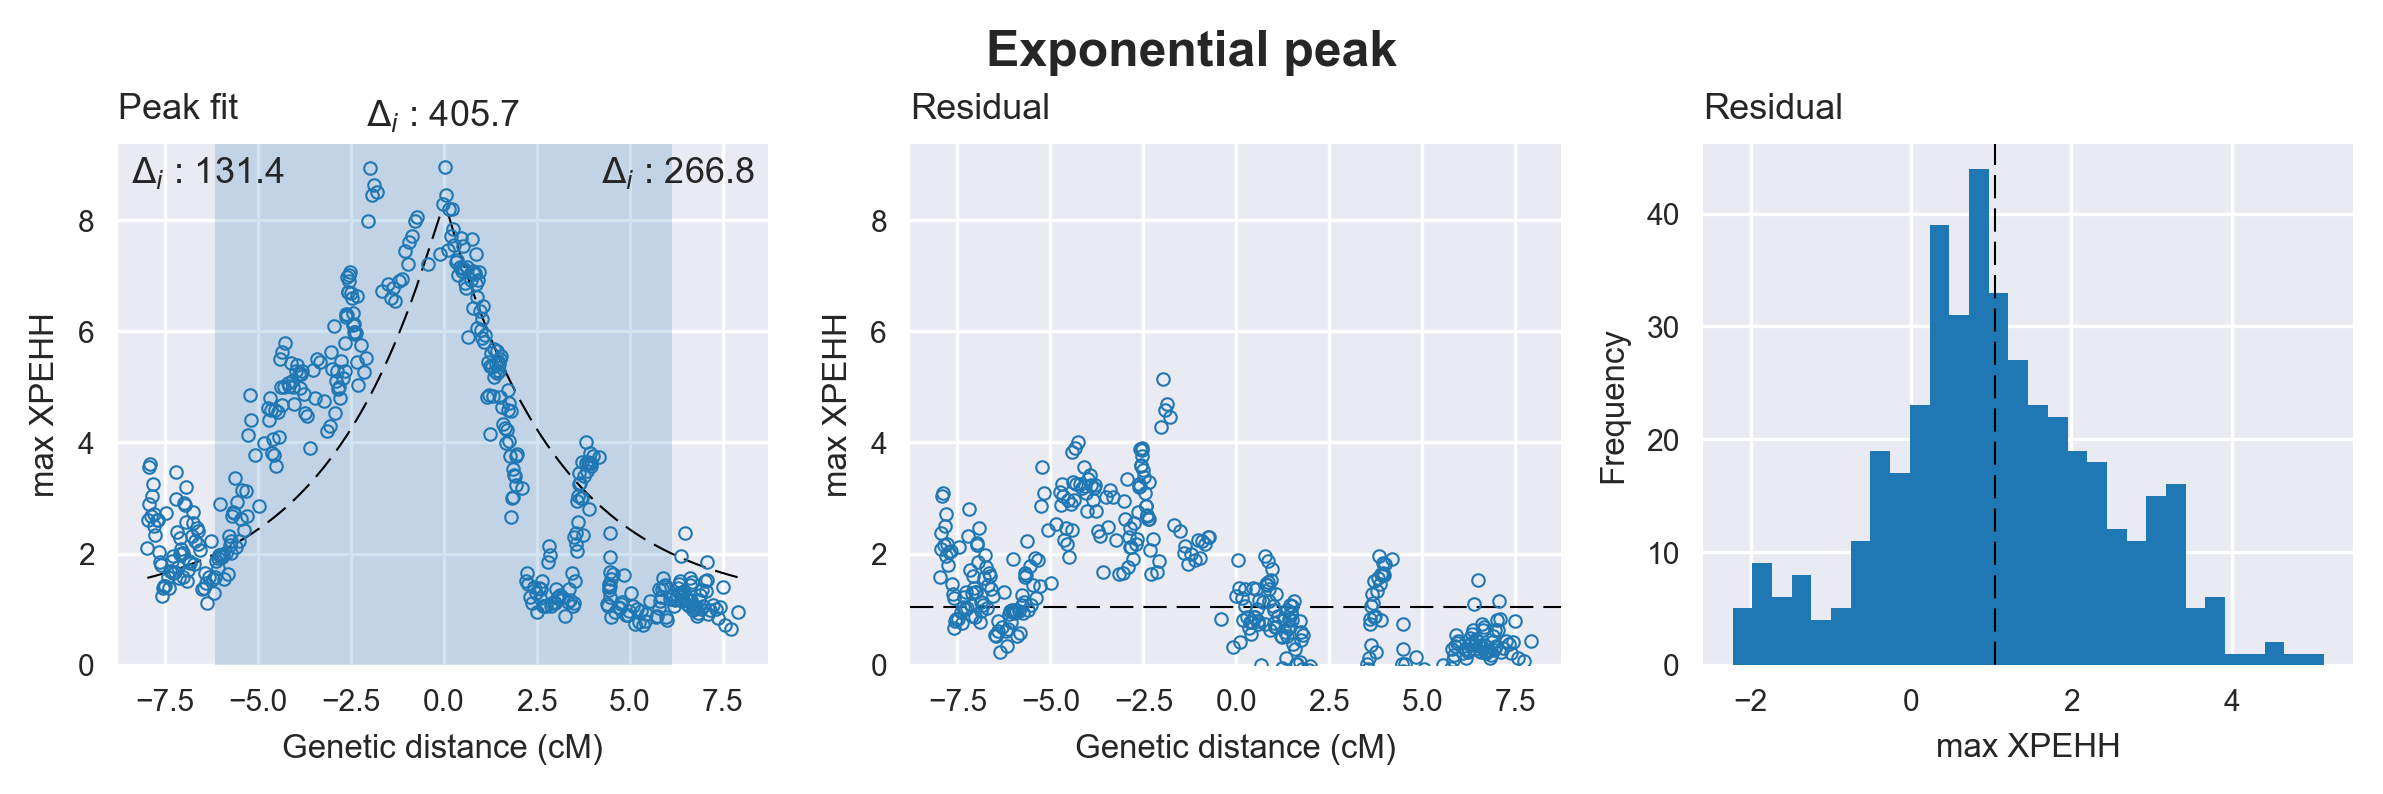

[[Model]]
    Model(exponential_peak)
[[Fit Statistics]]
    # function evals   = 56
    # data points      = 434
    # variables        = 4
    chi-square         = 820.429
    reduced chi-square = 1.908
    Akaike info crit   = 284.364
    Bayesian info crit = 300.656
[[Variables]]
    center:      0 (fixed)
    amplitude:   7.34319289 +/- 0.290873 (3.96%) (init= 3)
    decay:       2.99832272 +/- 0.378211 (12.61%) (init= 0.2)
    baseline:    1.04850354 +/- 0.313588 (29.91%) (init= 1)
    ceiling:     8.10889999 +/- 0.617733 (7.62%) (init= 5)
    floor:       0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(decay, baseline)           = -0.930 
    C(amplitude, baseline)       = -0.365 



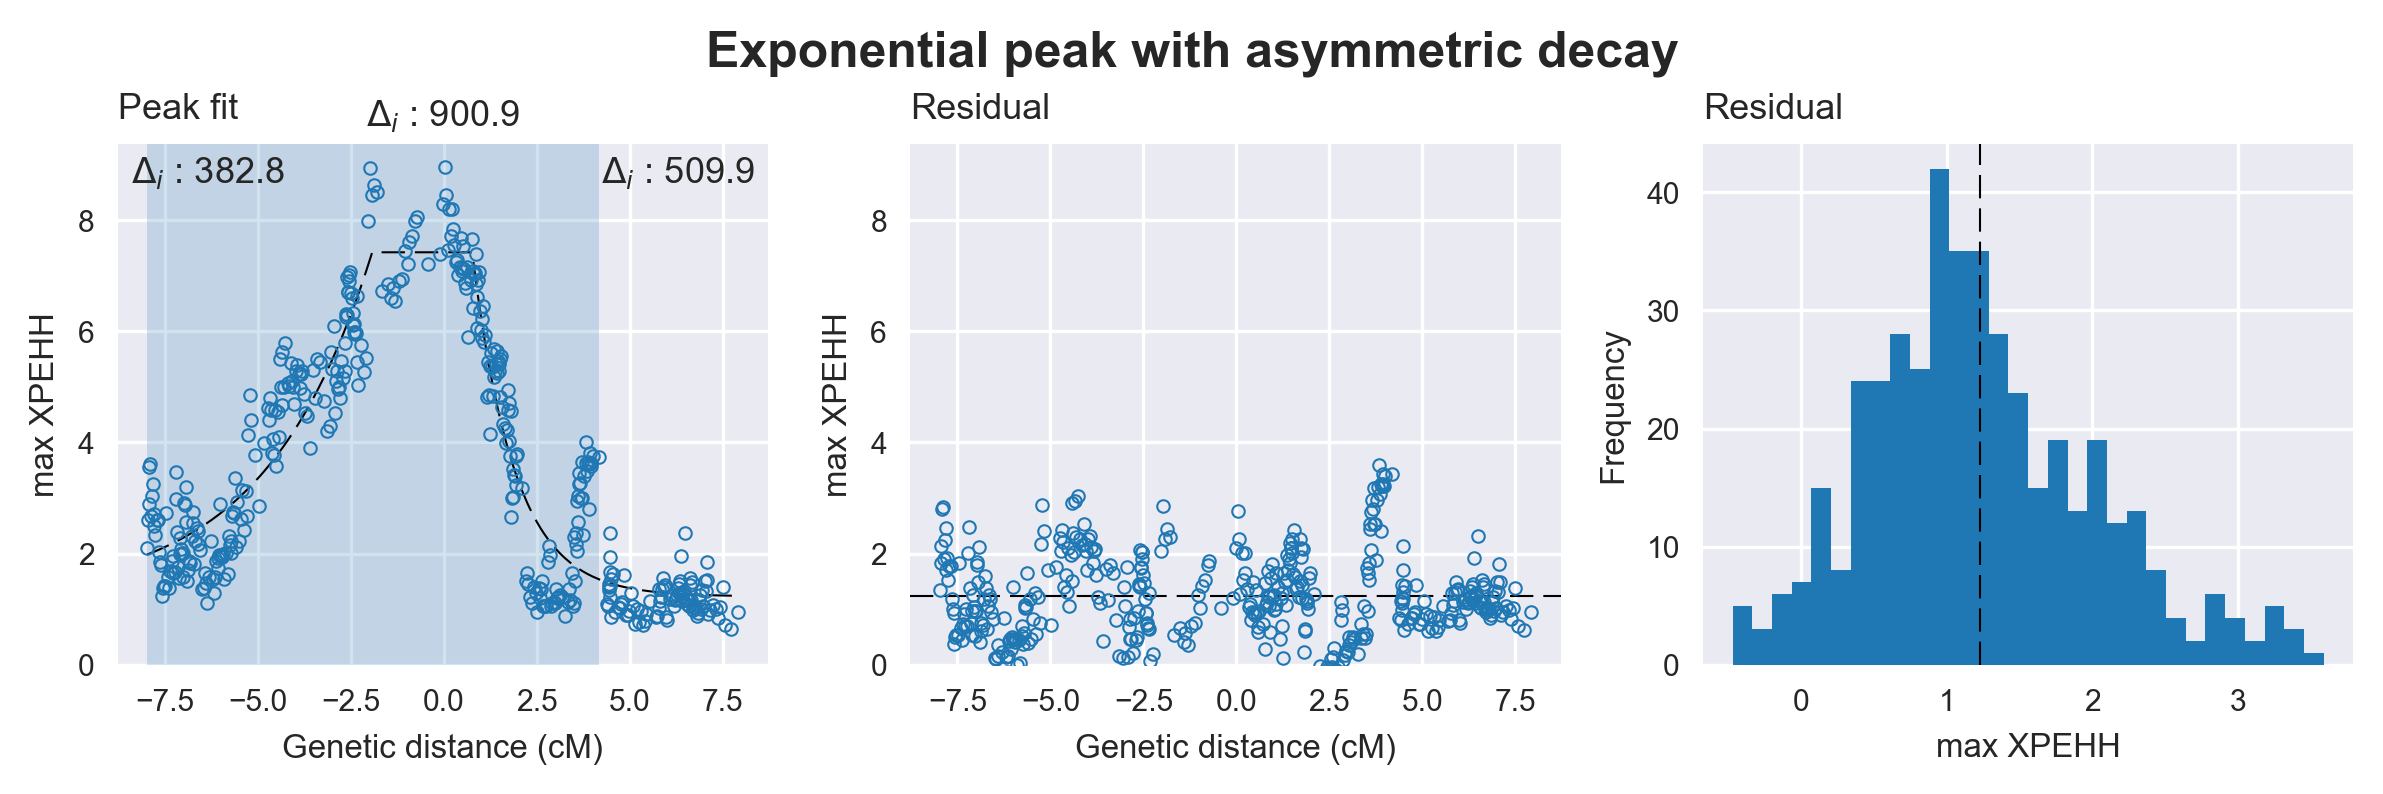

[[Model]]
    Model(asymmetric_decay_exponential_peak)
[[Fit Statistics]]
    # function evals   = 79
    # data points      = 434
    # variables        = 5
    chi-square         = 260.970
    reduced chi-square = 0.608
    Akaike info crit   = -210.749
    Bayesian info crit = -190.384
[[Variables]]
    center:        0 (fixed)
    amplitude:     12.1054484 +/- 0.572626 (4.73%) (init= 3)
    decay_left:    2.87126795 +/- 0.156320 (5.44%) (init= 0.2)
    decay_right:   1.13594240 +/- 0.066310 (5.84%) (init= 0.2)
    baseline:      1.22994868 +/- 0.087604 (7.12%) (init= 1)
    ceiling:       7.41813671 +/- 0.121807 (1.64%) (init= 5)
    floor:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(decay_left, decay_right)   =  0.887 
    C(amplitude, decay_left)     = -0.866 
    C(amplitude, decay_right)    = -0.834 
    C(decay_left, baseline)      = -0.736 
    C(decay_right, baseline)     = -0.736 
    C(amplitude, baseline)       =  0.437 



In [36]:
inspect_peak_fits(center=121, flank=8)

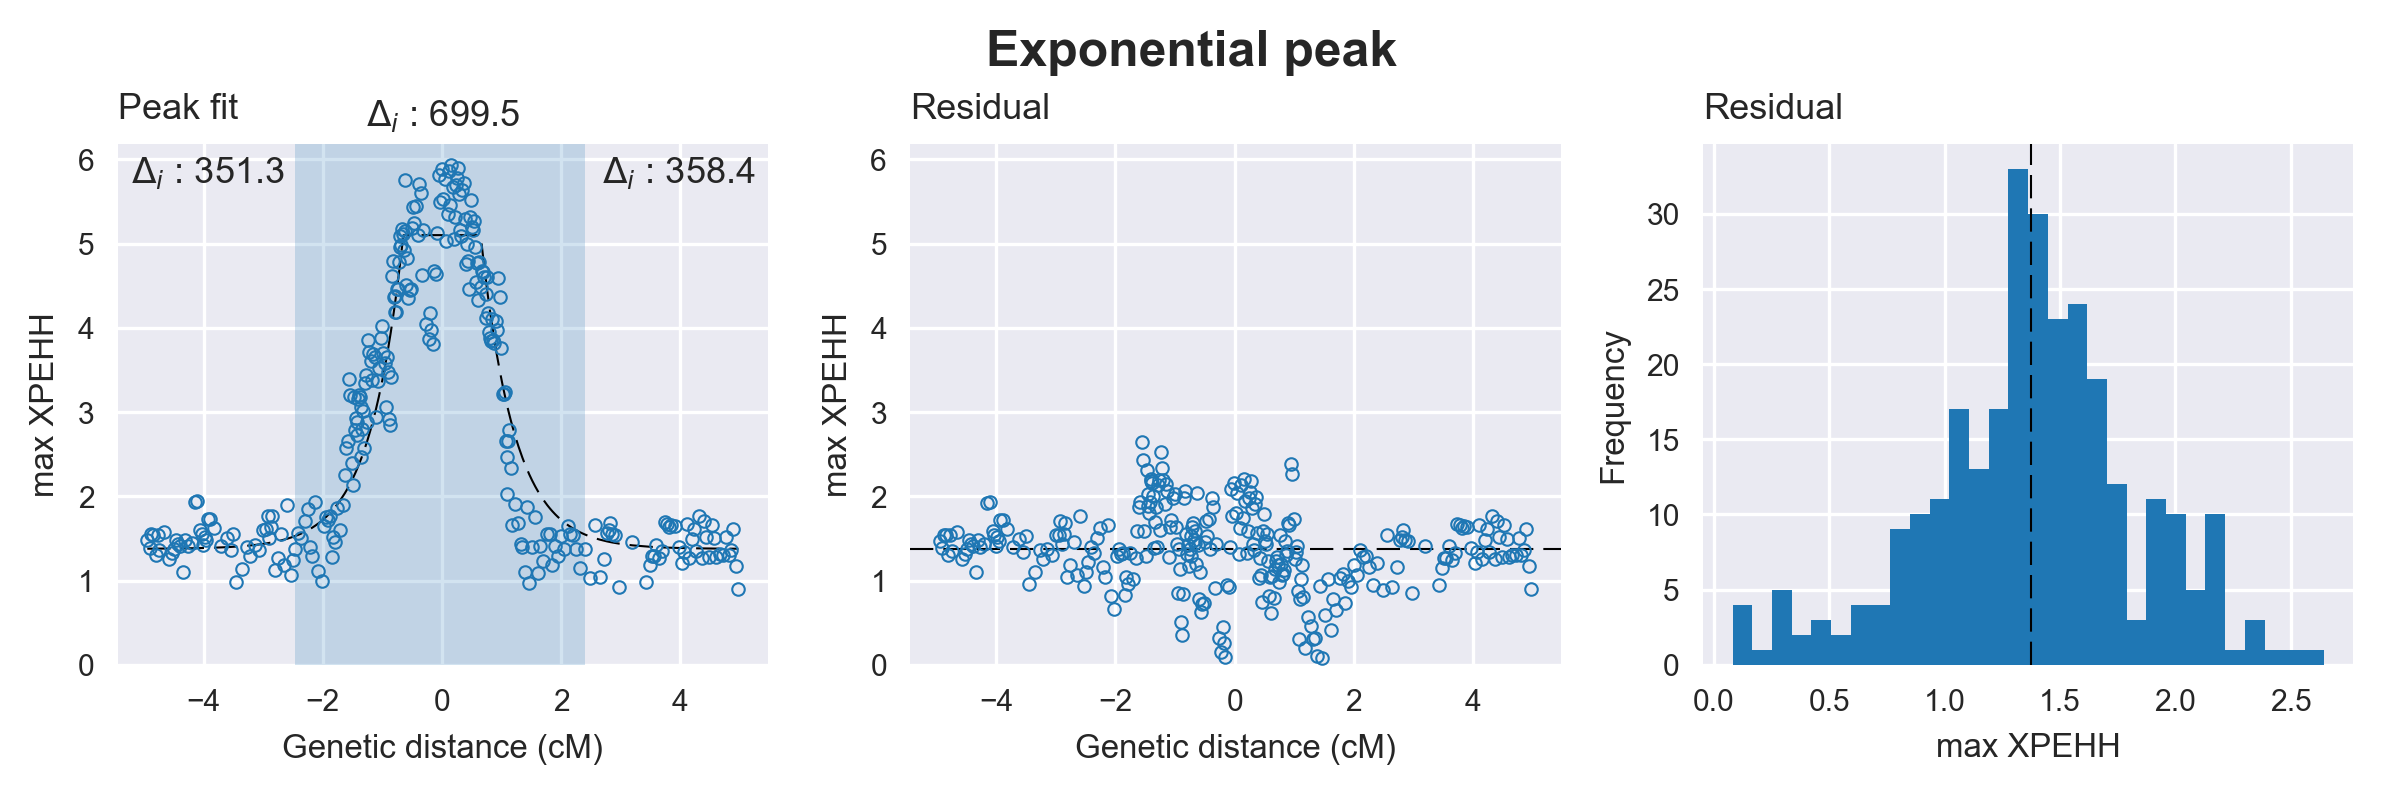

[[Model]]
    Model(exponential_peak)
[[Fit Statistics]]
    # function evals   = 74
    # data points      = 289
    # variables        = 4
    chi-square         = 61.423
    reduced chi-square = 0.216
    Akaike info crit   = -439.556
    Bayesian info crit = -424.890
[[Variables]]
    center:      0 (fixed)
    amplitude:   11.6805819 +/- 1.119464 (9.58%) (init= 3)
    decay:       0.56765191 +/- 0.038332 (6.75%) (init= 0.2)
    baseline:    1.37659787 +/- 0.049409 (3.59%) (init= 1)
    ceiling:     5.10051007 +/- 0.059440 (1.17%) (init= 5)
    floor:       0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, decay)          = -0.954 
    C(decay, baseline)           = -0.598 
    C(amplitude, baseline)       =  0.419 



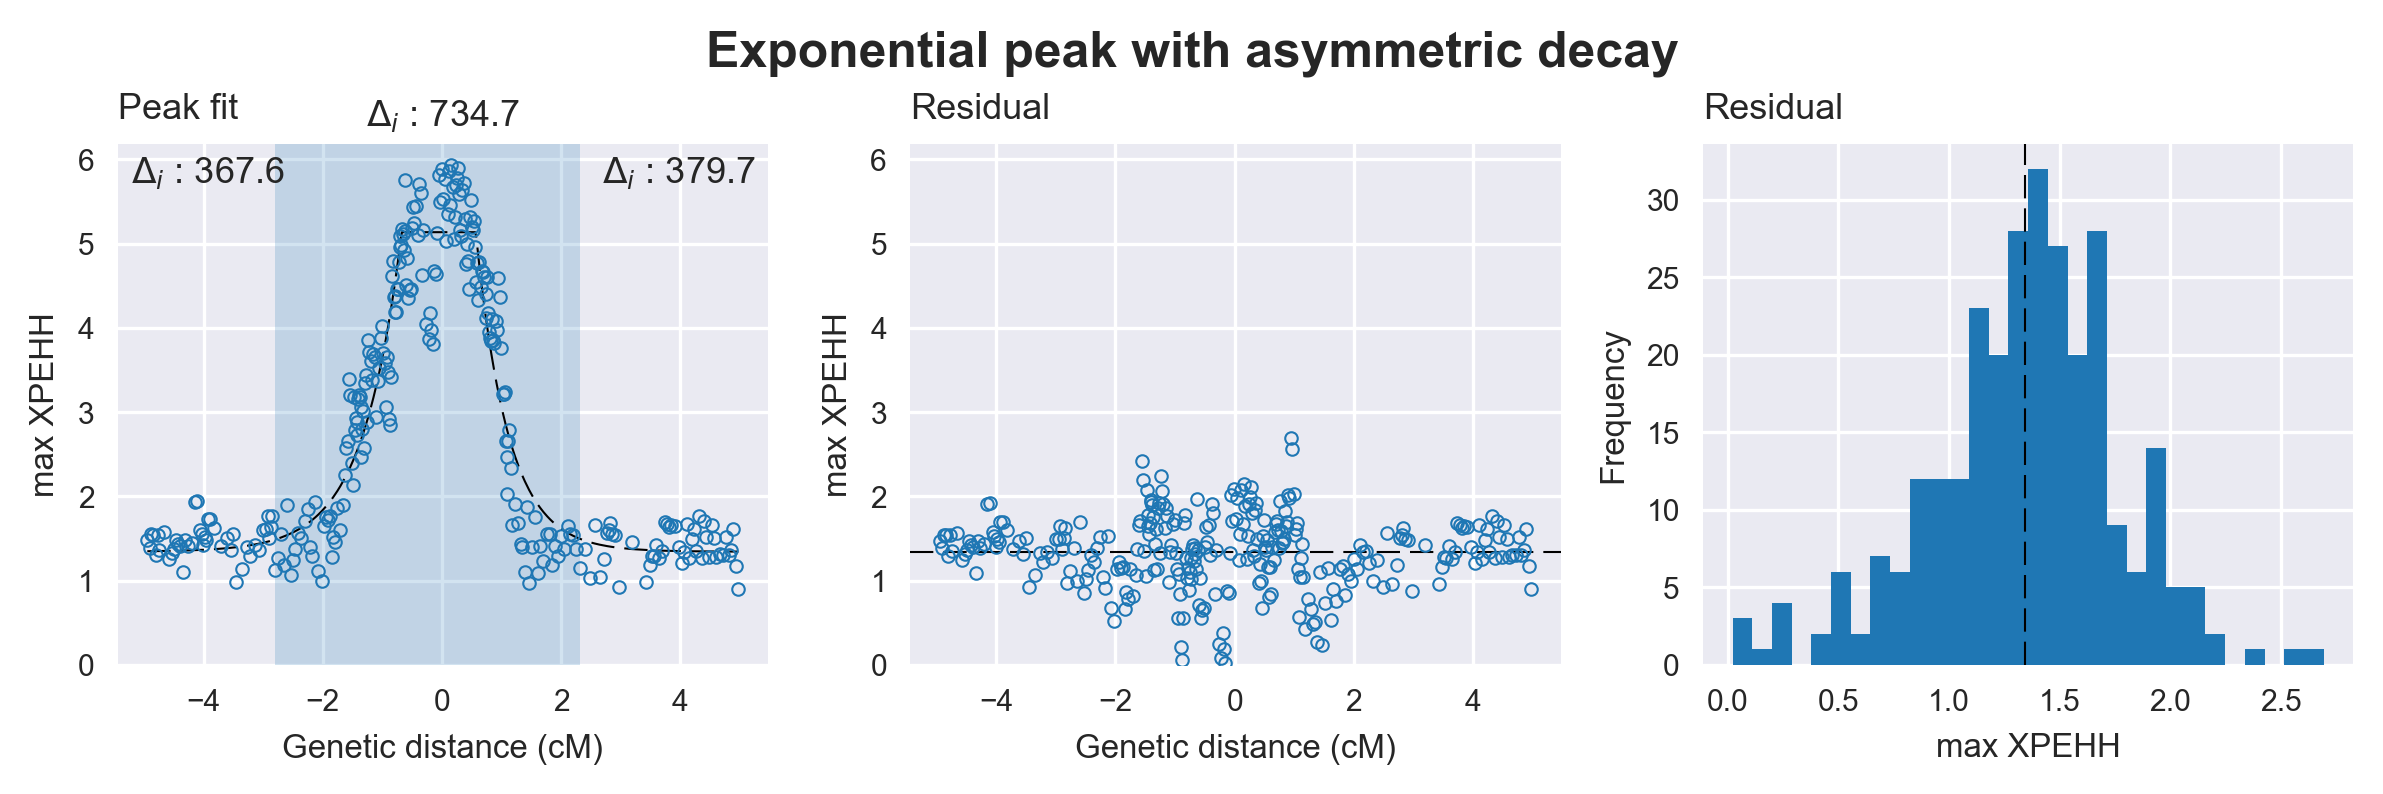

[[Model]]
    Model(asymmetric_decay_exponential_peak)
[[Fit Statistics]]
    # function evals   = 65
    # data points      = 289
    # variables        = 5
    chi-square         = 53.995
    reduced chi-square = 0.190
    Akaike info crit   = -474.807
    Bayesian info crit = -456.474
[[Variables]]
    center:        0 (fixed)
    amplitude:     10.7491462 +/- 0.876851 (8.16%) (init= 3)
    decay_left:    0.64981523 +/- 0.040684 (6.26%) (init= 0.2)
    decay_right:   0.54470572 +/- 0.034707 (6.37%) (init= 0.2)
    baseline:      1.34313095 +/- 0.047297 (3.52%) (init= 1)
    ceiling:       5.13548908 +/- 0.056766 (1.11%) (init= 5)
    floor:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, decay_left)     = -0.930 
    C(amplitude, decay_right)    = -0.918 
    C(decay_left, decay_right)   =  0.909 
    C(decay_left, baseline)      = -0.598 
    C(decay_right, baseline)     = -0.585 
    C(amplitude, baseline)       =  0.408 



In [37]:
inspect_peak_fits(center=170.8, flank=5)